**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
November 13, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 2: “Sequence Models”**
**Due**: Monday, November 27, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



Group 20

| Nachname     | Vorname | Matrikelnummer     |
|----------|-----|----------------|
| Mathew Biju     | Ibin  | 3770662 |
| Reddy    | Anu  | 3768482  |
| Yilmaz      | Burhan Akin  | 4114082    |
| Rijhwani      | Nilesh Parshotam  | 3771253    |

### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: Part-of-Speech Tagging with a Bidirectional LSTM**  (2+4+5=11 points)

In this task we will be building a sequence tagger that produces an output for every element in an input sequence, using `PyTorch` and `TorchText`, where `TorchText` consists of data processing utilities and popular datasets for natural language.


*   **input:** a sequence of text
*   **output:** part-of-speech (POS) tag for each token in the input text

We tackle this task using a multi-layer bi-directional LSTM (BiLSTM) to predict POS tags using the [Universal Dependencies](https://universaldependencies.org/) English Web Treebank (UDPOS) dataset. This dataset is contained in the `TorchText` library and we do not require an external file for it. The dataset in  `TorchText`  has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We only focus on the UD tags for this assignment.

In [1]:
%pip install portalocker

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install torchdata

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torchdata from https://files.pythonhosted.org/packages/08/05/d717b62841b32c29aabfb834d7fe606fdeb0420953b0391da1cde7804577/torchdata-0.7.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for torch>=2 from https://files.pythonhosted.org/packages/c7/1d/de42543b890ecbfc74786fdfdf80207f52c157fae4ac4c76612a8bb27a4a/torch-2.1.1-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     - -------------------------------------- 0.2/5.7 MB 5.9 MB/s eta 0:00:01
     -- ------------------------------------- 0.4/5.7 MB 4.9 MB/s eta 0:00:02
     ----- ---------------------------------- 0.7/5.7 MB 5.7 MB/s eta 0:00:01
     ------- -------------------------------- 1.1/5.7 MB 5.7 MB/s eta 0:00:01
     ---------- ----------------------------- 1.5/5.7 MB 6.2 MB/s eta 0:00:01
     ------------ --------------------------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.8.1 requires torch==1.7.1, but you have torch 2.1.1 which is incompatible.
torchvision 0.8.2+cu110 requires torch==1.7.1, but you have torch 2.1.1 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install torchtext

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/184.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/184.0 MB 2.8 MB/s eta 0:01:05
     ---------------------------------------- 0.4/184.0 MB 4.2 MB/s eta 0:00:44
     ---------------------------------------- 0.6/184.0 MB 4.3 MB/s eta 0:00:43
     ---------------------------------------- 0.9/184.0 MB 5.0 MB/s eta 0:00:37
     ---------------------------------------- 1.2/184.0 MB 5.4 MB/s eta 0:00:34
     ---------------------------------------- 1.4/184.0 MB 5.1 MB/s eta 0:00:36
     ---------------------------------------- 1.8/184.0 MB 5.8 MB/s eta 0:00:32
     ---------------------------------------- 2.1/184.0 MB 5.8 MB/s eta 0:00:32
      --------------------------------------- 2.4/184.0 MB 5.9 MB/s eta 0:00:31
      --------------------------------------- 2.8/184.0 MB 6.2 MB/s eta 0:00:30
      --------------------------------------- 3.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.1 requires torch>=2, but you have torch 1.7.1 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torchtext.datasets import UDPOS

import numpy as np

import time
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for reproducibility
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.backends.cudnn.deterministic = True

### Subtask 1: Data Analysis
The very basic components of the torchtext library include `vocab`, `word vectors`, and `tokenizer`. Those are the basic data processing building blocks for the raw text string.
In this case, we use the tokenizer and the vocabulary. Use the `build_vocab_from_iterator` to create the vocabulary for the text field and add the `<unk>` and `<pad>` tokens to it. Use a minimal frequency of `2`.
Also create a vocabulary for the labels (tag field). However, since the tags are predefined elements, you will not need an `<unk>` token.
 This dataset actually has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We train our model on the UD tags, which is the second element on the list of outputs (example below).


In [2]:
train_iter = iter(UDPOS(split="train"))
print(next(train_iter))

[['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']]


In [3]:
print(f"Number of training examples: {len(list(UDPOS(split='train')))}")
print(f"Number of validation examples: {len(list(UDPOS(split='valid')))}")
print(f"Number of testing examples: {len(list(UDPOS(split='test')))}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


Note that the data is already tokenized!

In [4]:
# Create vocabularies
def yield_tokens(data_iter, field):
    for item in data_iter:
        if field == 'text':
            yield item[0]
        elif field == 'ud_tags':
            yield item[1]

# Reset the iterator for text
train_iter = UDPOS(split="train")

# Create vocabulary for text
vocab = build_vocab_from_iterator(yield_tokens(train_iter, 'text'), specials=["<pad>", "<unk>"], min_freq=2, special_first=True)
vocab.set_default_index(vocab['<unk>'])

# Reset the iterator for UD tags
train_iter = UDPOS(split="train")

# Create vocabulary for UD tags, ensuring <pad> is first in the list of specials
ud_vocab = build_vocab_from_iterator(yield_tokens(train_iter, 'ud_tags'), specials=["<pad>"], special_first=True)
ud_vocab.set_default_index(ud_vocab['<pad>'])

Prepare a text processing pipeline that takes raw input and labels and converts them to ids.

In [5]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: ud_vocab(x)

In [6]:
print(text_pipeline(['the', 'preacher', 'at', 'mosque', "<pad>","pppp"])) #should output [3, 9271, 35, 9097, 0, 1]
print(label_pipeline(['DET', 'ADJ', 'NOUN', 'PUNCT'])) # should output [6, 8, 1, 2]

[3, 9271, 35, 9097, 0, 1]
[6, 8, 1, 2]


In [7]:
print(f"Unique tokens in input vocabulary: {len(vocab)}")
print(f"Unique tokens in UD vocabulary: {len(ud_vocab)}")

Unique tokens in input vocabulary: 9875
Unique tokens in UD vocabulary: 18


Write a custom function for the dataloader that applies the text and label pipeline and pads the sequences to have equal lengths.

In [8]:
from functools import partial

def collate_batch(batch, text_pipeline, label_pipeline, pad_token_ix, pad_token_ix_ud):
    text_list, label_list = [], []
    for item in batch:
        _text, _label, _ = item  # ignore PTB label
        processed_text = text_pipeline(_text)
        processed_label = label_pipeline(_label)
        text_list.append(torch.tensor(processed_text, dtype=torch.int64))
        label_list.append(torch.tensor(processed_label, dtype=torch.int64))

    x_padded = pad_sequence(text_list, batch_first=True, padding_value=pad_token_ix)
    y_padded = pad_sequence(label_list, batch_first=True, padding_value=pad_token_ix_ud)

    return x_padded, y_padded


collate_fn = partial(collate_batch, text_pipeline=text_pipeline, label_pipeline=label_pipeline, pad_token_ix=vocab['<pad>'], pad_token_ix_ud=ud_vocab['<pad>'])

train_dataloader = DataLoader(
    UDPOS(split="train"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    UDPOS(split="valid"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    UDPOS(split="test"), batch_size=128, shuffle=True, collate_fn=collate_fn
)

In [9]:
for idx, (label, text) in enumerate(train_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break


torch.Size([128, 57])
torch.Size([128, 57])
tensor([1832,   13,   17,  488, 2837,    3, 3074,    1, 5532,  512,   13,   23,
          56,  143,    5,  170,  154,  273,   39,  157,  971,   44, 2212,  648,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([14,  4,  9, 12,  3,  6,  1,  1, 10, 17,  4,  3, 10, 13,  5, 13,  1, 10,
        14,  9,  3,  5,  7,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])


Let's take a closer look at the data and the distribution of tags.
Implement `tag_percentage`:

*   Use the `collection.counter` to count the unique instances of each tag.

*    Compute the percentage of each tag in the entire set, by using the counted frequencies.



In [10]:
from collections import Counter

def tag_percentage(training_iterator):
    counter = Counter()
    #### code to count the number of tags
    for item in training_iterator:
        text, ud_tags, ptb_tags = item 
        counter.update(ud_tags) 

    total_tags = sum(counter.values())

    ### compute the tag percentages based on the counter object

    tag_p = [(tag, count, count / total_tags) for tag, count in counter.items()]
    ###
    return tag_p

In [11]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UDPOS(split='train')):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

PROPN		12946		 6.3%
PUNCT		23679		11.6%
ADJ		12477		 6.1%
NOUN		34781		17.0%
VERB		23081		11.3%
DET		16285		 8.0%
ADP		17638		 8.6%
AUX		12343		 6.0%
PRON		18577		 9.1%
PART		5567		 2.7%
SCONJ		3843		 1.9%
NUM		3999		 2.0%
ADV		10548		 5.2%
CCONJ		6707		 3.3%
X		847		 0.4%
INTJ		688		 0.3%
SYM		599		 0.3%


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: The Model

We start by creating a simple model and then make it more complex in later subtasks. The class `BiLSTMTagger` must subclass the `nn.Module` class of `PyTorch`. Fill the blank in the class by following the notes described below.
1.   The input is a sequence of tokens, $X = \{x_1, x_2,...,x_T\}$.
2.   Each token passes through  an embeddings layer, $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$. Use `nn.Embedding` for the embedding layer and make sure to pass in the index of the pad token.
3. Embedding is processed by forward and backward LSTMs from left to right and right to left.  The first input to the forward LSTM is $x_1$ and the first input to the backward LSTM is $x_T$. The hidden state of LSTMs is dependent on
the hidden, $h$, and cell, $c$, states from the previous time-steps:
$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
4. The hidden, $h$, and cell, $c$ of each layer is passed to the next layer, where the $h_0$ and $c_0$, for each direction and layer, are initialized to a tensor full of zeros. Use `nn.LSTM` for LSTM cells. How can you make it bidirectional?
5. Final hidden state is the concatenation of forward and backward hidden states from the final layer of the LSTM, $H = \{h_1, h_2, ... h_T\}$, where $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$. Use `nn.Linear` here.
6. The last layer is linear layer $f$, which is used to make the prediction of which tag applies to this token, $\hat{y}_t = f(h_t)$.
7. Define a `nn.Dropout` layer to apply to the embeddings and the outputs of the final layer of the LSTM.

In [71]:
import torch
import torch.nn as nn

class BiLSTMTagger(nn.Module):
    def __init__(self, hyperparameters):
        '''
        hyperparameters: is a dictionary containing:
            input_dim: dimension of the input
            embedding_dim: dimension of the embedding layer
            lstm_hidden_dim: dimension of the hidden state of lstms
            output_dim: dimension of the output hidden layer
            n_layers: number of layers to stack
            bidirectional: is the lstm bi-directional
            dropout: probability for the drop out layer
            pad_idx: id of the pad token
        '''
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=hyperparameters['input_dim'],
            embedding_dim=hyperparameters['embedding_dim'],
            padding_idx=hyperparameters['pad_idx']
        )

        # Bi-LSTM, apply dropout if the number of layers is more than 1
        self.lstm = nn.LSTM(
            input_size=hyperparameters['embedding_dim'],
            hidden_size=hyperparameters['lstm_hidden_dim'],
            num_layers=hyperparameters['n_layers'],
            bidirectional=hyperparameters['bidirectional'],
            dropout=hyperparameters['dropout'] if hyperparameters['n_layers'] > 1 else 0
        )

        # Linear layer for prediction
        self.fc = nn.Linear(
            in_features=hyperparameters['lstm_hidden_dim'] * 2 if hyperparameters['bidirectional'] else hyperparameters['lstm_hidden_dim'],
            out_features=hyperparameters['output_dim']
        )

        # Dropout layer
        self.dropout = nn.Dropout(hyperparameters['dropout'])

    def forward(self, text, debug=False):  # (B,S)
        '''
        S: sentence len
        B: batch size
        E: embedding size
        H: hidden size
        O: output size
        L: number of layers
        '''

        # Pass text through the embedding layer and a dropout layer
        embedded = self.dropout(self.embedding(text))

        # Pass embeddings into Bi-LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final hidden states from both directions if bidirectional
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        # Compute prediction
        predictions = self.fc(hidden)

        if debug:
            print("Input shape:", text.shape)
            print("Embedding shape:", embedded.shape)
            print("LSTM output shape:", outputs.shape)
            print("LSTM hidden shape:", hidden.shape)
            print("LSTM cell shape:", cell.shape)
            print("Output shape:", predictions.shape)

        return predictions


Response in plain text:
1. Based on the notation defined in the forward function. What is the dimension of `outputs`, `hidden`, and `cell`?

The dimension of outputs, hidden, and cell are defined as follows:

outputs: The output at each time step, where outputs is a tensor of shape (sequence_length, batch_size, hidden_size).

hidden: The final hidden state at each layer for each time step. hidden is a tensor of shape (num_layers, batch_size, hidden_size).

cell: The final cell state at each layer for each time step. cell is a tensor of shape (num_layers, batch_size, hidden_size).

The dimension of these tensors can vary based on the batch_first argument. If batch_first=True, the input tensor should be of shape (batch_size, sequence_length, input_size). In this case, the outputs tensor would have shape (batch_size, sequence_length, hidden_size).

In [72]:
hyper_parameters={
  'input_dim':  len(vocab),
  'embedding_dim': 100,
  'lstm_hidden_dim': 128,
  'output_dim':len(ud_vocab),
  'n_layers': 2 ,
  'bidirectional':True,
  'dropout': 0.25,
  'pad_idx': vocab['<pad>']
}
model = BiLSTMTagger(hyper_parameters)

In [73]:
input=torch.tensor([[3, 9271, 35, 9097, 0, 1],
                    [3, 9271, 35, 9097, 0, 1]])
model(input,debug=True).shape

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([6, 256])
LSTM cell shape: torch.Size([4, 6, 128])
Output shape: torch.Size([6, 18])


torch.Size([6, 18])

Weights of the network are initialized randomly, so let's make a more systematic initialization to help us with the optimization. For example,  Xavier Initialization creates weights such that the variance of the activations is the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. However, it does not apply to bias terms.

Create a function that uses Xavier Initialization to initialize the weights of the network, for biases use a normal distribution with a mean of 0 and a standard deviation of 0.1.

In [15]:
import torch.nn.init as init

def init_weights(m):
    if type(m) == nn.Linear:
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.normal_(m.bias, mean=0, std=0.1)
    elif type(m) == nn.Embedding:
        init.xavier_uniform_(m.weight)

# Applying the initialization to the model
model.apply(init_weights)
model.to(device)

BiLSTMTagger(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Let's count the number of trainable parameters in our model.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of trainable parameters:",count_parameters(model))

number of trainable parameters: 1622910


####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Training

We start by defining a loss function and an optimizer.


*   **optimizer:** We use Adam with the learning rate=0.0001.
*   **loss:** We use cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens to create batches of the same size. However, we do not want to calculate loss on those tokens, so make sure you define your loss function in such a way that ignores the `<pad>` tokens.




In [17]:
import torch.nn.functional as F

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Loss function (ignores <pad> tokens)
pad_idx = hyper_parameters['pad_idx']
loss_function = nn.CrossEntropyLoss(ignore_index=pad_idx)

Watching the loss go down as you train a model is a good indication of the correct training procedure, but does not tell us how well we are doing on a given task.
To this end, we also implement a categorical accuracy measure to keep track of how well our model is doing on a given task.
Same as before: we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.
Implement the function `categorical_acc` to compare the prediction of non-pad tokens with labels count the correct ones and calculate the accuracy over a single batch.

In [29]:
import torch

def categorical_acc(preds, gt, pad_idx):
    """
    Returns categorical accuracy per batch
    """
    # Get the index of the max probability
    max_preds = preds.argmax(dim=1)

    # Create a mask for non-padding positions
    non_pad_mask = gt != pad_idx

    # Count the correct predictions where the ground truth is not <pad>
    correct = torch.sum(max_preds[non_pad_mask] == gt[non_pad_mask]).item()

    # Count the total number of non-pad tokens
    total_non_pad = non_pad_mask.sum().item()

    # Calculate accuracy
    accuracy = correct / total_non_pad if total_non_pad > 0 else 0

    return accuracy


In [30]:
dummpy_input=torch.tensor([
    [0.9,0,0,0],
    [0.1,0.9,0,0],
    [0.1,0,0,0.9],
    [0.9,0.1,0,0],
    [0.1,0.8,0,0]

])
categorical_acc(dummpy_input, torch.tensor([0,2,3,0,1]), 0)

0.6666666666666666

Define the `train` model that performs one epoch of training. You can refer to the Tutorial 2 of the course to get a sample workflow. The only difference to the tutorial is that we keep track of the batch-wise accuracy as well as the loss.

In [40]:
def train(model, dataloader, optimizer, loss_function, pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    epoch_start_time = time.time()

    for batch_idx, (text, tags) in enumerate(dataloader):
        # Check for empty batches
        if text.size(0) == 0:
            continue

        # zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text)

        # Ensure predictions and tags have the same size
        if predictions.size(1) != tags.size(1):
            print(f"Predictions shape {predictions.size()} does not match tags shape {tags.size()}.")
            continue

        # compute the loss, ignoring <pad> token
        loss = loss_function(predictions.view(-1, predictions.shape[-1]), tags.view(-1))

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Compute categorical accuracy
        acc = categorical_acc(predictions, tags, pad_idx)

        # Update epoch loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc

    end_time = time.time() - epoch_start_time

    # Ensure division by zero is avoided
    if len(dataloader) == 0:
        length_dataloader = 1
    else:
        length_dataloader = len(dataloader)

    return epoch_loss / length_dataloader, epoch_acc / length_dataloader, end_time


It is not enough to only look at the training loss and accuracy, since with more training, we can always do better on the training set, but lose the generalizability to unseen data, a phenomenon known as **overfitting**. Therefore, it is important to check the loss and accuracy on the validation set after each epoch and stop before  overfitting occurs. Moreover, we can use the validation metric as an indication of which checkpoint of our model is the best.

Define an `evaluate` function that runs once through the validation set and computes loss and accuracy. **Note:** You should not be updating gradients here and your model should be in evaluation mode.

In [32]:

def evaluate(model, dataloader, loss_function, pad_idx):
    val_loss = 0
    val_acc = 0

    model.eval()  # Set the model to evaluation mode
    length_dataloader = len(dataloader)

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch_num, (text, tags) in enumerate(dataloader):
            # Forward pass
            predictions = model(text)

            # Compute the loss, ignoring <pad> tokens
            loss = loss_function(predictions.view(-1, predictions.shape[-1]), tags.view(-1))

            # Compute categorical accuracy
            acc = categorical_acc(predictions, tags, pad_idx)

            # Update validation loss and accuracy
            val_loss += loss.item()
            val_acc += acc

    return val_loss / length_dataloader, val_acc / length_dataloader

Let's use the functions defined so far and train our model for `30` epochs. We suggest using GPU for this task, as it is quite slow on the CPU. Run the training loop for the given number of epochs and calculate the validation metric at the end of each epoch. Based on the validation loss, save the best checkpoint of the model.

In [41]:
epochs = 30

best_valid_loss = float('inf')
print("pad_idx:", hyper_parameters['pad_idx'])


for epoch in range(epochs):
    # Training
    train_loss, train_acc, epoch_time = train(model, train_dataloader, optimizer, loss_function, hyper_parameters['pad_idx'])

    # Validation
    valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_function, hyper_parameters['pad_idx'])

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
    elapsed_mins = int(epoch_time / 60)
    elapsed_secs = int(epoch_time - (elapsed_mins * 60))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')


print("pad_idx:", hyper_parameters['pad_idx'])


pad_idx: 0


TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not PackedSequence

Question:

1. Does overfitting occur? If so, after which epochs?

2. How do you detect overfitting?


**Answer:**
```
Write your answer here.
```

Let's see how well our model is doing on the test set. Load the best checkpoint and calculate the accuracy.

In [ ]:
#### you code ####

#### you code ####
test_acc

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Inference

Let's use the model we trained to tag some actual sentences. We have the preprocessing pipeline ready from Subtask 1, now we need to map the predictions back to label texts for each token.

Implement the `tag_sequence` function that takes a model and a sentence as input and generates POS tags. Keep in mind that you need to divide the sentence into tokens first. For this purpose, we just split each sentence on whitespaces.

In [ ]:
def tag_sentence(model, sentence):
    ### your code ###


    predictions = # make predictions on th esentence


    predicted_tags = # get the tags
    ### your code ###
    return predicted_tags

In [ ]:
text=" ".join(list(UDPOS(split='test'))[0][0])
label= list(UDPOS(split='test'))[0][1]
predicted_tag=tag_sentence(model,text)
print("Text: ",text)
print("Predicted Tags: ",predicted_tag)
print("True Tags: ",label)

####${\color{red}{Comments\ 1.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Theoretical Questions** (0.5+1.5+1+3=6 points)

### Subtask 1:
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

**Answer:**


```
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

a) runtime: 
Increasing the beam width in beam search leads to a linear rise in runtime, as it requires evaluating more potential paths per iteration. The computational effort and runtime grow with the number of candidates proportional to the beam size.
a)Memory:
A wider beam in beam search increases memory usage, as it stores more candidate sequences along with their associated data like scores and states, potentially straining memory in limited-capacity systems.
b) the quality of results:
Increasing the beam width in beam search can lead to better results by exploring more options. However, after a certain point, the improvement in results doesn't make up for the extra time and resources needed. Also, if the beam is too wide, the search might focus on less important sequences, especially if it's not good at picking the best ones from a larger group.





```



####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2:
Except for beam search, there are other ways to create a more coherent output for generation tasks, one of which is adding a temperature to the softmax over the vocabulary. Temperature is a hyperparameter that is applied to the input of a softmax to affect the final probabilities. All values in the input are divided by the temperature before going through the softmax. What do you think will happen in these cases:

1. A low temperature - below 1
2. A high temperature - above 1
3. Really small temperature - temperature $→$ 0

**Answer:**
```
1. A low temperature - below 1:
Below 1, the softmax function produces a "sharper" probability distribution, which means the most likely tokens have a higher probability and the least likely tokens have a lower probability. In turn, this can lead to more conservative and deterministic outputs. In the context of text generation, a low temperature may lead to more predictable and repetitive sequences, as the model becomes more confident and selects the most likely tokens with greater assurance.
2.High Temperature (Above 1):
On the other hand, a high temperature, above 1, results in an even distribution of probabilities across the vocabulary.
It can also lead to more diverse and exploratory outcomes since the model becomes less certain about its predictions and assigns more comparable probabilities to different tokens. Text generation is encouraged by a high temperature because the model becomes less constrained and more open to exploring different options, resulting in more creative sequences.
3. Really small temperature - temperature $→$ 0
At low temperatures, the softmax function tends toward a "hard" distribution, where the probability mass is increasingly concentrated on the most likely token, making the distribution more deterministic. In the context of text generation, an extremely small temperature can lead to highly repetitive and predictable outputs
```

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3:
Explain what the “bottleneck” of an encoder-decoder RNN is and how attention provides a way to get around this bottleneck.

**Answer:**
```
The bottleneck of an encoder-decoder RNN stems from the fixed-length vector representation of the input sequence, which can limit the model's ability to process long sequences effectively. Attention provides a solution to this bottleneck by enabling the model to dynamically focus on different parts of the input sequence during the decoding process, thereby enhancing its ability to handle longer sequences and capture relevant information more effectively
```

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4:
As mentioned, there are various way to remedy the repetitiveness and incoherence of generation outputs. One of the widely used methods is Nucleus sampling described the paper "[ The Curious Case of Neural Text DeGeneration](https://arxiv.org/pdf/1904.09751.pdf)". Read the model section and introduction of the paper and use it as reference to answer the following questions:

1. Describe top-k sampling in your own words, no need for mathematical notation.
2. Describe Nucleus sampling in your own words, there is not need for mathematical notation.
3.  Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?


**Answer:**
```
1.Describe top-k sampling in your own words, no need for mathematical notation.
In text generation, a useful technique is the top-k sampling method. To implement this technique, first, k words are chosen from the model's probability distribution at each time step. The selected value of k never changes throughout the process. Next, the probability distribution is altered according to the total probabilities of the top k words. Lastly, a word is randomly chosen from the adjusted distribution, and this process is conducted repeatedly until the desired length of text is achieved. Compared to beam search, top-k sampling gives superior control over the variety of the produced text. The challenge lies in finding the perfect k value, where a low k might bring about unexciting or repeated text, whereas a high k may present improper choices.
2.Describe Nucleus sampling in your own words, there is not need for mathematical notation.
Selective text creation, also known as nucleus sampling, is a novel strategy that addresses the shortcomings of commonly used sampling methods such as pure sampling and top-k sampling. Rather than selecting a specified number of likely words, nucleus sampling extracts a component of the lexicon that represents a specific percentage of the total probability mass. This unit, termed "the nucleus," can change in size in accordance with the probability distribution of each time step. Nucleus sampling focuses on the most likely words by eliminating lower probability words that can result in nonsensical or poorly connected phrases. High k values must be avoided when using nucleus sampling to introduce diversity while avoiding incoherence concerns. The proportion of the probability mass determined by a parameter called p determines the size of the nucleus.
3.Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?
Beam search is an ineffective technique for human-like text generation since it favors the most likely terms at each time step, resulting in repetitious and generic content. This is because language models reward well-formed content, but the top results for longer texts are frequently generic, repetitive, and clunky. Human-written text, on the other hand, tends to be more varied and instructive, with lower probabilities allocated to more informative but less predictable terms.
By incorporating randomness into the selection of words, nucleus sampling and other stochastic decoding approaches such as top-k sampling overcome this problem, allowing for more variation in output text. Nucleus sampling, in particular, concentrates on the most likely words while avoiding the untrustworthy tail of low probability words, which might result in incoherent or unrelated material. Nucleus sampling ensures that the generated text is both high-quality and diversified, akin to human-written text
```

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Scaled Dot-Product Attention** (4+1=5 points)
In class, you learned about attention and Transformers as described in the 2017 paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762).
The base of the attention module is a scaled dot product with Queries, Keys, and Values.
In this task, you will implement a simplified version of scaled dot-product attention and inspired by the translation task, aim to replicate word alignment between English and French.
You will not be training the embedding from scratch, we provide you with pre-trained embedding for both languages.
However, you need to know the details of scaled dot product attention, which mainly consists of two matrix multiplications and a softmax scaling.
Refer to Figure 2 of the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

The inputs of the attention module are Queries, Keys, and Values. Mathematically, attention is defined as follows:

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$


*   $Q$, $K$, and $V$ are the Queries, Keys, and Values matrices.
* $d_k$ is the dimension of the Keys (in practice dimensions of all matrices are the same).
*   $QK^{\top}$ is a measure of the similarity between the Queries and the Keys
* softmax transforms the similarity into weights.
* Weights multiplied by the Values are the output of the attention, defining how much importance should be given to each token of the input.

In the case of self-attention, both Queries and Keys come from the encoder, however, for cross attention between encoder and decoder, decoder states are used as the queries while encoder states are the Keys and Values.
In our case, we need the cross attention between one language to another to find the correct alignment.


In [ ]:
%pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#load the dictionaries (dictionary of words to ids)
with open("./word2int_en.pkl", "rb") as f:
    en_dict = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
    fr_dict = pickle.load(f)

# load word embeddings (dictionary of token ids to embeddings)
en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]


### Subtask 1: Attention Weights
Fill the blanks in `tokenize` to tokenize a sentence and convert it to ids and `embed` function to create an embedding of a sentence.

In [ ]:
def tokenize(sentence, token_mapping):
   # we stick to simple blank space tokenization
   tokenized = []
   for word in sentence.lower().split(" "):
      token_id = token_mapping.get(word,-1)
      tokenized.append(token_id)
   return tokenized

def embed(tokens, embeddings):
    """ get the embedding for the tokens in a sentence stacked in a simple matrix (sequence length, embedding size)
        tokens: tokenized sentence
        embeddings: dictionary of token to embeddings.
    """
    embed_size = embeddings.shape[1]
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token != -1:
            output[i] = embeddings[token]
        else:
            output[i] = np.zeros(embed_size)
    # Note that the return statement is outside the for loop
    return output

In [ ]:
sentence_en = "there were clouds in my coffeeeeee."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)
print("Tokenized english:",tokenized_en)
print("embedding english:",embedded_en.shape)

sentence_fr = "il y avait des nuages ​​dans mon ccafé."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
print("Tokenized french:",tokenized_fr)
print("embedding french:",embedded_fr.shape)

Tokenized english: [59, 40, 9355, 6, 158, -1]
embedding english: (6, 300)
Tokenized french: [21, 73, 192, 16, 8652, -1, 558, -1]
embedding french: (8, 300)


✅ Point distribution ✅
- 0.5 if the tokenizations are [59, 40, 9355, 6, 158, -1] and [21, 73, 192, 16, 8652, -1, 558, -1], check the tokenizers code if the values differ to see if the logic is correct to assign partial points. If the value of the unknown token is not exactly -1 then it is ok, but it should be considered.
- 0.5 if the shape of the embeddings are (6, 300) and (8, 300), if loaded properly the shapes should match, otherwise check the code.


Implement the `softmax` function with `Numpy`.


In [ ]:
def softmax(x, axis=0):
    """
    x: input matrix
    axis: defines which axis to compute the softmax over 0 for rows and 1 for columns
        axis=0 calculates softmax across rows which means each column sums to 1
        axis=1 calculates softmax across columns which means each row sums to 1
    """

    #### your code ####
    e_x = np.exp(x-np.max(x,axis=axis,keepdims=True))
    
    softmax_x= e_x/np.sum(e_x,axis=axis,keepdims=True)
    #### your code ####

    return softmax_x

In [ ]:
w=softmax(np.array([[1,3,4,1], [24,3,2,3]]),axis=0)
w.sum(axis=0)[0]

1.0

✅ Point distribution ✅
- 0.5 if the sum is 1.0, if not check the code.
- 0.5 if the axis=axis, keepdims=True are also set.

Use the `softmax` function to calculate the weights.
$$ \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
Assume the queries and keys are 2D matrices.

In [ ]:
def calc_weights(queries, keys):
    """
    queries: queries matrix
    keys: keys matrix
    """
    #### your code ####
    #calculate the dimensions of the keys
    d_k = keys.shape[1]  # Assuming keys is a 2D matrix of shape [num_keys, key_dimension]
    raw_scores = np.matmul(queries, keys.T)
    scaled_scores = raw_scores / np.sqrt(d_k)
    print("Raw scores:")
    print(raw_scores)
    print("Scaled scores:")
    print(scaled_scores)
    return softmax(scaled_scores, axis=1)
    #### your code ####


In [ ]:
weights=calc_weights(np.array([[1,3],[1,3]]),np.array([[0,3],[2,3]]))
print(weights)
weights.sum(axis=1)[0]

Raw scores:
[[ 9 11]
 [ 9 11]]
Scaled scores:
[[6.36396103 7.77817459]
 [6.36396103 7.77817459]]
[[0.19557032 0.80442968]
 [0.19557032 0.80442968]]


1.0

✅ Point distribution ✅
- 0.5 if the sum is 1.0, if not check the code.
- 0.5 if the weights are :
                            [[0.19557032 0.80442968]
                            [0.19557032 0.80442968]].

Use the `calcu_weights` to compute the attention matrix between two sentences from English and French and visualize the weights to check for alignments.

Raw scores:
[[ 0.11143156 -0.11918585 -0.11104156  0.18105114 -0.03099746 -0.06891545
   0.16896826  0.          0.18105114  0.17189078  0.        ]
 [ 0.23277421 -0.02150457 -0.11164849  0.14258683 -0.0749176   0.00824908
   0.14113042  0.          0.14258683  0.04867125  0.        ]
 [-0.02766669  0.18549792 -0.13051698  0.02532783 -0.02940436 -0.05491569
  -0.02074198  0.          0.02532783  0.03975966  0.        ]
 [ 0.1332272   0.13820109 -0.02096431  0.17196022 -0.09233489 -0.02274998
   0.28538581  0.          0.17196022  0.31356981  0.        ]
 [-0.08841272 -0.09345124  0.56232713 -0.00463369  0.00131161 -0.01447119
   0.03417505  0.         -0.00463369  0.01371714  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-0.00854627 -0.08358519  0.00771695 -0.02131187  0.39898962  0.0087569
   0.05460894  0.         -0.02131187  0.07041253  0.        ]
 [-0.04822296 -0.11248157 -0.03778477 

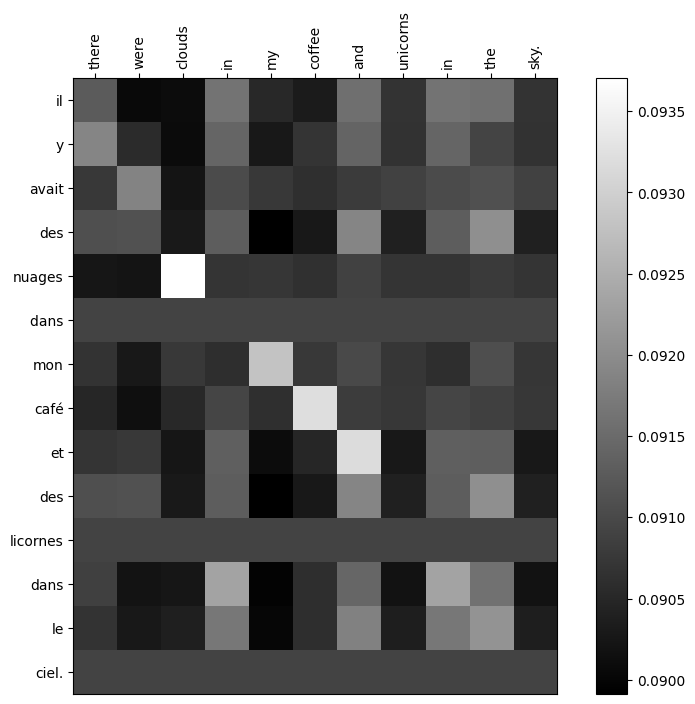

In [ ]:
sentence_en = "there were clouds in my coffee and unicorns in the sky."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "il y avait des nuages ​​dans mon café et des licornes dans le ciel."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
# Compute the range of the alignment matrix for visualization scaling
alignment = calc_weights(embedded_fr, embedded_en)

# Inspect the alignment matrix
print("Alignment matrix:")
print(alignment)

# Check the range of the alignment matrix
alignment_min = np.min(alignment)
alignment_max = np.max(alignment)


# Visualize the weights with adjusted color scale
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(alignment, cmap='gray', aspect='equal', vmin=alignment_min, vmax=alignment_max)
fig.colorbar(cax)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(sentence_en.split(" "))))
ax.set_xticklabels(sentence_en.split(" "), rotation=90)
ax.set_yticks(np.arange(len(sentence_fr.split(" "))))
ax.set_yticklabels(sentence_fr.split(" "))

# Print the range of values in the alignment matrix
print("Alignment matrix value range: ", alignment_min, alignment_max)

# Compute and print the top-2 alignments
top_2 = np.argsort(-alignment, axis=1)[:, :2]
print('The top 2 alignments (French to English):')
for i, row in enumerate(top_2):
    french_word = sentence_fr.split(" ")[i]
    english_words_alignment = [sentence_en.split(" ")[index] for index in row]
    print(f"French word '{french_word}': Top English words: {english_words_alignment}")

plt.show()

1. What are the top 2 alignments shown in the figure?
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?

**Answer:**

```
1.What are the top 2 alignments shown in the figure?
French word 'licornes': Top English words: ['there', 'were']
French word 'dans': Top English words: ['in', 'in']
French word 'le': Top English words: ['the', 'and']
French word 'ciel.': Top English words: ['there', 'were']
2.On the rows you see flat lines for ciel and dans and licornes, why do you think that is?
The flat lines in the heatmap rows for "ciel," "dans," and "licornes" indicate that these French words are being given nearly equal attention weights across all English words. This can be for teh following reasons:
1. If the embeddings do not capture the nuances between different words well, the model may not be able to distinguish between them effectively.
2.The attention model might be too simple or not trained appropriately to capture the complexity of the word alignments between the two languages.
```

✅ Point distribution ✅
- 0.5 if the sum is 1.0, if not check the code.
- 0.5 if the weights are :
                            [[0.19557032 0.80442968]
                            [0.19557032 0.80442968]].

####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
The implementation of the tokenize and embed functions works exactly the same as the one in the solutions.

The softmax function in the solutions is numerically more stable than your implementation because they used a trick for numerical stability by subtracting the maximum value in the input array (np.max(x, axis=axis, keepdims=True)) from x before computing the exponential. 
Of course, your implementation is correct too.

Unfortunately, you did not correctly find the top 2 alignments. 
The main problem here is that you have performed row-wise sorting. For example, if your -alignments are as follows:
-alignments = [[-1, -3, -2],
               [-4, -6, -5]]
For the first row [-1, -3, -2], the sorted order is [-3, -2, -1]. 
The indices to achieve this order in the original row are [1, 2, 0]. 
For the second row [-4, -6, -5], the sorted order is [-6, -5, -4]. 
The indices to achieve this order in the original row are [1, 2, 0]. 
This means your top 2 word (row-col) indices are as follows:
- For the first word: (the id of the column with the highest value in the row 0, the id of the column with the second highest value in the row 1)
- For the second word: (the id of the column with the highest value in the row 0, the id of the column with the second highest value in the row 1)
(-0.5)

Unfortunately, your explanation for the reason of seeing a flat line for ciel, dans, and licornes is not correct. 
The reason is that these three words are out of vocabulary, and we used np.zeros() as the embedding of these words. 
Every dot product with a vector full of zeros is always 0. To sum up, we have no embeddings for these words and used np.zeros() which is the reason for the flat lines.
(-0.5)

All other things are almost identical and have an exact match with the ones in the solutions.

Total Points: 3 / 4

```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Scaled Dot-product
Implement the scaled dot-product attention using the functions from above.



In [ ]:
def attention(queries, keys, values):
    """  scaled dot-product attention
    queries: query matrix
    keys: key matrix
    value: value matrix
    """

    #### your code ####
    weights = calc_weights(queries,keys)
    attention = np.matmul(weights,values)
    #### your code ####
    return attention


attention_result = attention(embedded_fr, embedded_en, embedded_en)
print(attention_result.shape)


Raw scores:
[[ 0.11143156 -0.11918585 -0.11104156  0.18105114 -0.03099746 -0.06891545
   0.16896826  0.          0.18105114  0.17189078  0.        ]
 [ 0.23277421 -0.02150457 -0.11164849  0.14258683 -0.0749176   0.00824908
   0.14113042  0.          0.14258683  0.04867125  0.        ]
 [-0.02766669  0.18549792 -0.13051698  0.02532783 -0.02940436 -0.05491569
  -0.02074198  0.          0.02532783  0.03975966  0.        ]
 [ 0.1332272   0.13820109 -0.02096431  0.17196022 -0.09233489 -0.02274998
   0.28538581  0.          0.17196022  0.31356981  0.        ]
 [-0.08841272 -0.09345124  0.56232713 -0.00463369  0.00131161 -0.01447119
   0.03417505  0.         -0.00463369  0.01371714  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-0.00854627 -0.08358519  0.00771695 -0.02131187  0.39898962  0.0087569
   0.05460894  0.         -0.02131187  0.07041253  0.        ]
 [-0.04822296 -0.11248157 -0.03778477 

In [ ]:
print(attention_result[0:2,:10])

[[-0.0077802  -0.00345834 -0.01493142  0.05936939 -0.02286767 -0.00835552
   0.00079745 -0.03737862  0.0270674   0.05374082]
 [-0.00777829 -0.00336843 -0.01498988  0.05937157 -0.02285948 -0.00835695
   0.00085725 -0.03740797  0.02706951  0.05377672]]


✅ Point distribution ✅
- 0.5 if the shape is (14, 300).
- 0.5 if the selected rows are:

```
[[-0.0077802  -0.00345834 -0.01493142  0.05936939 -0.02286767 -0.00835552
   0.00079745 -0.03737862  0.0270674   0.05374082]
 [-0.00777829 -0.00336843 -0.01498988  0.05937157 -0.02285948 -0.00835695
   0.00085725 -0.03740797  0.02706951  0.05377672]]
   ```

If these checks do not match, check the code.

####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```

Good job! There is an exact match, and the implementation is correct!

Total Points: 1 / 1
```


${\color{red}{⚠️Comments\ end⚠️}}$

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1bcdaf6-328f-4516-bd85-cdc48d4f60b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>